In [1]:
import numpy as np
from scipy.linalg import eig
from scipy.sparse.linalg import eigs
from scipy.sparse import eye, diags
import kwant

import matplotlib.pyplot as plt

In [115]:
%%time
N = 10000
a = 0.1
Emax = 1
Emin = -1

E_max_abs = np.max(np.abs([Emax, Emin]))

H = diags(np.linspace(Emin, Emax, N))

def G_operator(ham, Emax, Emin):
    Emax=Emax+0.05
    Emin=Emin-0.05
    E0 = (Emax - Emin)/2
    Ec = (Emax + Emin)/2
    return (ham - eye(ham.shape[0]) * Ec)/E0


def F_operator(ham, Emax, a):
    Emax=Emax+0.05
    E0 = (Emax**2 - a**2)/2
    Ec = (Emax**2 + a**2)/2
    return (ham @ ham - eye(ham.shape[0]) * Ec)/E0

G = G_operator(H, Emax, Emin)
F = F_operator(H, E_max_abs, a)
a_r = a/E_max_abs


dos_estimate = kwant.kpm.SpectralDensity(
    H,
    energy_resolution=a/10,
    mean=True,
    bounds=(Emin, Emax)
)

step = lambda E: np.heaviside(E + a, 0) * np.heaviside(a - E, 0)

d=int(dos_estimate.integrate(step).real)

CPU times: user 294 ms, sys: 11.9 ms, total: 306 ms
Wall time: 303 ms


In [116]:
def low_E_filter(ψ_rand, H, k):
    for i in range(k+1):
        if i == 0:
            ψ_n = ψ_rand
            continue
            
        if i == 1:
            ψ_nm1 = ψ_n
            ψ_n = H.dot(ψ_nm1)
            continue
            
        ψ_np1 = 2*H.dot(ψ_n) - ψ_nm1
        ψ_nm1 = ψ_n
        ψ_n = ψ_np1
        
    return ψ_n

def basis(ψ_proj, H, indices):
    ψ_basis = []
    k = indices[-1]
    for i in range(k+1):
        if i == 0:
            ψ_n = ψ_proj
            continue
            
        if i == 1:
            ψ_nm1 = ψ_n
            ψ_n = H.dot(ψ_nm1)
            continue
            
        ψ_np1 = 2*H.dot(ψ_n) - ψ_nm1
        ψ_nm1 = ψ_n
        ψ_n = ψ_np1
        
        if i in indices:
            ψ_basis.append(ψ_n)
    return ψ_basis

CPU times: user 43.6 ms, sys: 3.98 ms, total: 47.6 ms
Wall time: 44.8 ms


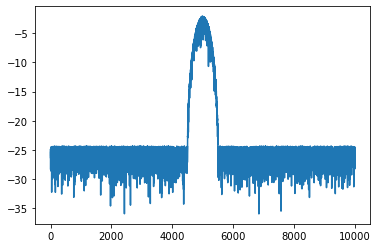

In [117]:
%%time
ψ_rand = np.random.rand(N)
ψ_rand = ψ_rand/np.linalg.norm(ψ_rand)
ψ_proj = low_E_filter(ψ_rand, F, int(12/a))
ψ_proj = ψ_proj/np.linalg.norm(ψ_proj)

plt.plot(np.log(np.abs(ψ_proj)))

In [123]:
%%time
n = int((d*3 - 1)/2)
Kd = int(n*np.pi/a_r)
indices = np.arange(np.pi/a_r, (n+1)*np.pi/a_r, np.pi/a_r).astype(int)

ψ_basis = basis(ψ_proj, G, indices) ## The bottleneck step

norm = np.linalg.norm(ψ_basis, axis=1)
ψ_basis = ψ_basis/norm[:, np.newaxis]

CPU times: user 2.77 s, sys: 326 ms, total: 3.1 s
Wall time: 3.09 s


In [124]:
%%time
S = ψ_basis@ψ_basis.T
H_proj = ψ_basis@H.dot(ψ_basis.T)

CPU times: user 1.99 s, sys: 148 ms, total: 2.14 s
Wall time: 2.14 s


In [125]:
%%time
s, V = eig(S)
indx = np.abs(s)>1e-12
lambda_s = np.diag(1/np.sqrt(s[indx]))
U = V[:, indx]@lambda_s

H_proj_red = U.T.conj()@H_proj@U

CPU times: user 3.97 s, sys: 56 ms, total: 4.02 s
Wall time: 4 s


In [126]:
%%time
# could use eigh, H_proj_red is approximately hermitian
eigvalues, eigvectors = eig(H_proj_red)

CPU times: user 2.71 s, sys: 40.1 ms, total: 2.75 s
Wall time: 2.72 s


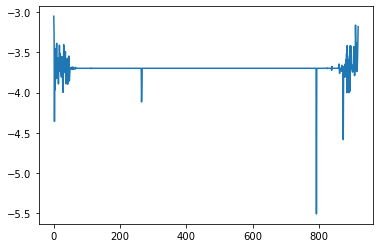

In [127]:
plt.plot(np.log10(np.diff(np.sort(np.real(eigvalues)))))

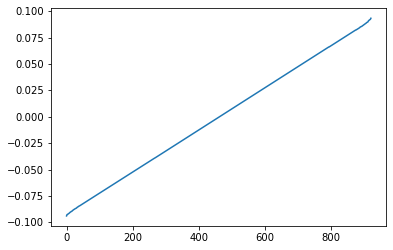

In [128]:
plt.plot(np.sort(np.real(eigvalues)))

In [129]:
import kwant

dos = kwant.kpm.SpectralDensity(
    H_proj_red,
    mean=True,
    bounds=(-a, a),
    energy_resolution=0.005
)

/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


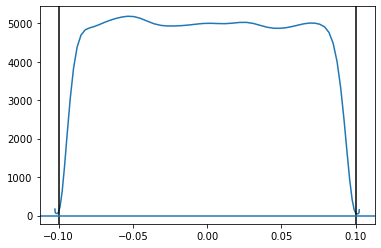

In [130]:
plt.plot(*dos())
plt.axvline(-a, c='k')
plt.axvline(a, c='k')
# plt.xlim(-a, a)
# plt.ylim(-1e59, 1e59)
plt.axhline(0)
plt.show()